### part0:imports

In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        reload(lstm)
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')

import warnings
warnings.filterwarnings("ignore")

Done


### Get data

In [2]:
BIN_SIZE = 0.03
def prep_general (df):
    "preprocessing general!"
    time_signals = [signal for signal in pyal.get_time_varying_fields(df) if 'spikes' in signal]
    # df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values
    df['session'] = df.monkey[0]+':'+df.date[0]
    
    for signal in time_signals:
        df_ = pyal.remove_low_firing_neurons(df, signal, 1)
        # print('Neurons (all, left):', df[signal].values[0].shape[1], df_[signal].values[0].shape[1])
    
    #combine pmd and m1
    MCx_signals = [signal for signal in time_signals if 'M1' in signal or 'PMd' in signal]
    if len(MCx_signals) > 1:
        df_ = pyal.merge_signals(df_, MCx_signals, 'MCx_spikes')
    elif len(MCx_signals) == 1:
        df_['MCx_spikes'] = df_[MCx_signals[0]].copy() #TODO: diff from orig prep_general
    time_signals = [signal for signal in pyal.get_time_varying_fields(df_) if 'spikes' in signal]

    #select trials
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    #get rates
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in time_signals:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    return df_

In [3]:
datadir = pathlib.Path("/home/jcc319/data/random_walk")
# datadir = pathlib.Path("/home/jcc319/multi_animal_alignment/data")
_AllAnimalList = ['Chewie', 'Mihili', "MrT"]

_AllAnimalFiles=[]
for animal in _AllAnimalList:
    _AllAnimalFiles.extend(utility.find_file(datadir / animal, 'mat'))
# print(_AllAnimalFiles)


In [4]:
rows = []
for file in _AllAnimalFiles:
    raw_df = pyal.mat2dataframe(file, shift_idx_fields=True)
    df = prep_general(raw_df);

    dic = {
        'animal': file.split(os.sep)[-2],
        'file': file,
        'trials_all': len(raw_df),
        'trials_left': len(df),
        'areas': [x for x in list(raw_df.columns) if '_spikes' in x],
        'neurons_all': [raw_df[x][0].shape[0] for x in list(raw_df.columns) if '_spikes' in x],
        'neurons_left': [df[x][0].shape[0] for x in list(df.columns) if '_spikes' in x]
    }
    rows.append(dic)

summary = pd.DataFrame(rows)
summary


,animal,file,trials_all,trials_left,areas,neurons_all,neurons_left
0,Chewie,/home/jcc319/data/random_walk/Chewie/Chewie_RT...,486,157,[M1_spikes],[366],"[122, 122]"
1,Chewie,/home/jcc319/data/random_walk/Chewie/Chewie_RT...,509,134,[M1_spikes],[534],"[178, 178]"
2,Chewie,/home/jcc319/data/random_walk/Chewie/Chewie_RT...,529,148,[M1_spikes],[316],"[151, 151]"
3,Chewie,/home/jcc319/data/random_walk/Chewie/Chewie_RT...,588,154,[M1_spikes],[297],"[99, 99]"
4,Chewie,/home/jcc319/data/random_walk/Chewie/Chewie_RT...,634,157,[M1_spikes],[595],"[198, 198]"
5,Chewie,/home/jcc319/data/random_walk/Chewie/Chewie_RT...,553,164,[M1_spikes],[345],"[115, 115]"
6,Chewie,/home/jcc319/data/random_walk/Chewie/Chewie_RT...,530,135,[M1_spikes],[387],"[129, 129]"
7,Chewie,/home/jcc319/data/random_walk/Chewie/Chewie_RT...,628,159,[M1_spikes],[319],"[106, 106]"
8,Chewie,/home/jcc319/data/random_walk/Chewie/Chewie_RT...,577,147,[M1_spikes],[334],"[111, 111]"
9,Chewie,/home/jcc319/data/random_walk/Chewie/Chewie_RT...,291,288,"[M1_spikes, PMd_spikes]","[347, 347]","[115, 115, 115]"


In [5]:
file = _AllAnimalFiles
all_dfs = []
for file in _AllAnimalFiles:
    #get data
    raw_df = pyal.mat2dataframe(file, shift_idx_fields=True)
    df = prep_general(raw_df)
    df = pyal.restrict_to_interval(df, start_point_name = 'idx_trial_start', end_point_name = 'idx_trial_end')

    #fix target and position locations
    df['target_center'] = [np.reshape(x.T.flatten(), x.shape, order = 'C') for x in df['target_center']]
    mean_pos = np.mean(np.vstack(df.pos), axis = 0)
    # df['pos'] = [x - mean_pos for x in df['pos']] 
    all_dfs.append(df)

In [6]:
ex1 = 11
ex2 = 12
df = all_dfs[ex1]


### Check rates

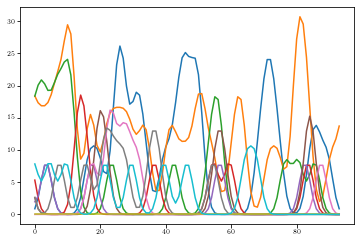

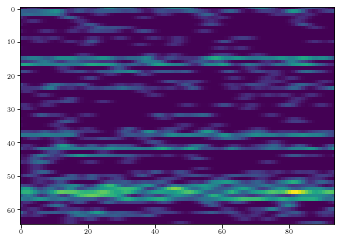

In [7]:
%matplotlib inline
rates = df.MCx_rates.values[0]
# print(df_reaches.columns)
plt.figure()
for i in range(10):
    plt.plot(rates[:,i])
    
fig, ax = plt.subplots()
ax.imshow(rates.T)


### separate into reaches

In [8]:
all_reach_dfs = []
all_reach_move_dfs = []
n_target_groups = 8
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                        rel_start=int(0.0/BIN_SIZE),
                                        rel_end=int(0.35/BIN_SIZE)
                                        )

for j,df in enumerate(all_dfs[:]):
    # ntrials = 8
    # plt.figure()
    # for pos,targets in zip(df.pos[:ntrials], df.target_center[:ntrials]):
    #     plt.plot(*pos[:].T)
    #     plt.scatter(*targets[:].T, s = 10)
    # plt.gca().set_aspect(1)

    df_reaches = pd.DataFrame()
    df[['idx_go_cue1',
        'idx_go_cue2',
        'idx_go_cue3',
        'idx_go_cue4']] = pd.DataFrame(df.idx_go_cue.tolist(), index= df.index)

    #separate by reaches
    for i in range(4):
        start_point_name = 'idx_go_cue' +str(i+1)
        end_point_name = ('idx_go_cue' + str(i+2)) if i < 3 else 'idx_trial_end'
        df_ = pyal.restrict_to_interval(df, start_point_name, end_point_name)
        if i>0:
            df_['start_center'] = [x[i-1] for x in df_['target_center']] #assume reach starts in target of prev reach
        df_['target_center'] = [x[i] for x in df_['target_center']]
        df_['reach'] = i+1
        df_['idx_go_cue']= df_[start_point_name]
        df_['idx_reach_end'] = df_[end_point_name] - df_[start_point_name] 
        df_reaches = pd.concat([df_reaches, df_])
    df_reaches = df_reaches.sort_values(by=['trial_id', 'reach'])
    df_reaches = df_reaches[df_reaches.idx_reach_end < 200] #TODO: better cutoff for slow reaches

    #fix pos offset
    df_second_reaches = df_reaches[df_reaches.reach == 2] #look at offset for second reach
    idx = [all(np.abs(x) < 100) for x in df_second_reaches.start_center] #remove wrong positions
    df_second_reaches = df_second_reaches[idx]
    mean_offset = np.mean([pos[0] - start_center for start_center,pos in zip(df_second_reaches.start_center, df_second_reaches.pos)],axis = 0) 
    df_reaches['pos'] = [x - mean_offset for x in df_reaches['pos']] 

    #center targets and pos at origin
    df_reaches['dist_start_center'] = [np.linalg.norm(x[0]) for x in df_reaches.pos]
    df_reaches['pos_centered'] = [x - x[0] for x in df_reaches.pos]
    df_reaches['target_centered'] = [y - x[0] for x,y in zip(df_reaches.pos,df_reaches.target_center)]

    # get target angle and group
    df_reaches['target_angle'] = [math.degrees(math.atan2(x[1],x[0])) for x in df_reaches.target_centered]
    df_reaches['target_angle'] = [360+x if x < 0 else x for x in df_reaches.target_angle]
    df_reaches['target_group'] = [math.floor(x/(360/n_target_groups)) for x in df_reaches.target_angle]

    #look at exec_epoch only
    for col in df_reaches.columns:  #TODO: placeholder to prevent bug in pyaldata
        if 'unit_guide' in col:
            df_reaches = df_reaches.drop([col], axis = 1)
    df_reaches = pyal.add_movement_onset(df_reaches)
    df_reaches_move = pyal.restrict_to_interval(df_reaches, epoch_fun=exec_epoch)
    df_reaches_move.reset_index()

    # print('Trials (total, movement):', len(df_reaches), len(df_reaches_move))
    
    all_reach_dfs.append(df_reaches)
    all_reach_move_dfs.append(df_reaches_move)

    # ntrials = 8
    # plt.figure()
    # for pos,targets in zip(df_reaches.pos[:ntrials], df_reaches.target_center[:ntrials]):
    #     plt.plot(*pos[:].T)
    #     plt.scatter(*targets[:].T, s = 10)
    # plt.gca().set_aspect(1)


### look at reaches

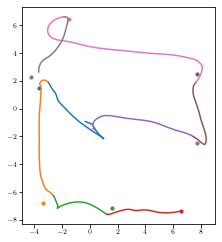

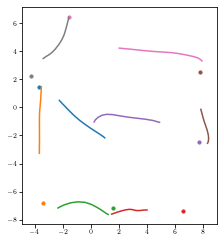

In [9]:
%matplotlib inline
df_reaches = all_reach_dfs[9]
df_reaches_move = all_reach_move_dfs[9]

#whole trial
ntrials = 8
plt.figure()
for pos,targets in zip(df_reaches.pos[:ntrials], df_reaches.target_center[:ntrials]):
    plt.plot(*pos[:].T)
    plt.scatter(*targets[:].T, s = 10)
plt.gca().set_aspect(1)

#movement epoch
plt.figure()
for pos,targets in zip(df_reaches_move.pos[:ntrials], df_reaches_move.target_center[:ntrials]):
    plt.plot(*pos[:].T)
    plt.scatter(*targets[:].T, s = 10)
plt.gca().set_aspect(1)

#### plot positions

Trials (subset, subset_movement): 262 233


(-10.0, 10.0)

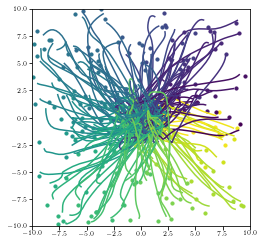

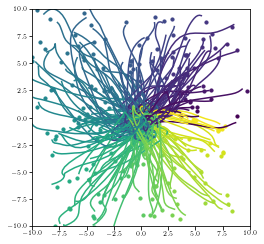

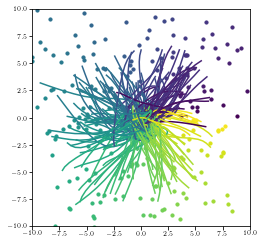

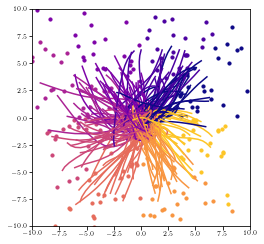

In [10]:
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, 360)

#subset reaches that start around the center
ntrials = 200
plt.figure()
df_center = df_reaches[df_reaches.dist_start_center <2.5]
for i in range(ntrials):
    pos = df_center.pos.values[i]
    targets = df_center.target_center.values[i]
    angle = df_center.target_angle.values[i]
    plt.plot(*pos[:].T, c=cmap(norm(angle)))
    plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

#subset reaches that start around the center, centered reaches
plt.figure()
for i in range(ntrials):
    pos = df_center.pos_centered.values[i]
    targets = df_center.target_centered.values[i]
    angle = df_center.target_angle.values[i]
    plt.plot(*pos[:].T, c=cmap(norm(angle)))
    plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

#subset reaches that start around the center, centered reaches, movement only
df_center_move = df_reaches_move[df_reaches_move.dist_start_center <2.5]
plt.figure()
for i in range(ntrials):
    pos = df_center_move.pos_centered.values[i]
    targets = df_center_move.target_centered.values[i]
    angle = df_center_move.target_angle.values[i]
    plt.plot(*pos[:].T, c=cmap(norm(angle)))
    plt.scatter(*targets[:].T, s = 10, c=cmap(norm(angle)))
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

print('Trials (subset, subset_movement):', len(df_center), len(df_center_move))

#subset reaches that start around the center, centered reaches, movement only, grouped
colors = utility.get_colors(n_target_groups)
df_center_move = df_reaches_move[df_reaches_move.dist_start_center <2.5]
plt.figure()
for i in range(ntrials):
    pos = df_center_move.pos_centered.values[i]
    targets = df_center_move.target_centered.values[i]
    target_group = df_center_move.target_group.values[i]
    plt.plot(*pos[:].T, c=colors[target_group])
    plt.scatter(*targets[:].T, s = 10, c=colors[target_group])
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

In [ ]:
#match the most similar ones to the largest session (9)
#look at distances to targets, and find the most similar ones

#### subset trials

In [57]:
subset_radius = 2.5

for i in range(len(all_reach_dfs)):
    reach_df = all_reach_dfs[i]
    move_df = all_reach_move_dfs[i]

    #subset for whole trial
    df_ = reach_df[reach_df.dist_start_center < subset_radius]
    rates = np.concatenate(df_['MCx_rates'].values, axis=0)
    rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
    df_ = pyal.apply_dim_reduce_model(df_, rates_model, 'MCx_rates', '_pca');
    df_ = df_.reset_index()
    all_reach_dfs[i] = df_


    #subset for movement epoch
    df_ = move_df[move_df.dist_start_center < subset_radius]
    rates = np.concatenate(df_['MCx_rates'].values, axis=0)
    rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
    df_ = pyal.apply_dim_reduce_model(df_, rates_model, 'MCx_rates', '_pca');
    df_ = df_.reset_index()
    all_reach_move_dfs[i] = df_ 

In [67]:
all_reach_move_dfs[0].head()

,index,monkey,date,task,target_center,trial_id,result,bin_size,perturbation,perturbation_info,...,idx_reach_end,start_center,dist_start_center,pos_centered,target_centered,target_angle,target_group,vel_norm,idx_movement_on,_pca
0,0,Chewie,12-13-2013,RT,"[6.837241172790527, -1.1846615076065063]",1,R,0.03,VR,0.52,...,NaN,NaN,2.373629,"[[-0.4550825339864888, -0.6908799212472445], [...","[4.770409761711916, -0.01747567539391781]",359.790107,7,"[1.8186260137769368, 6.525322046006412, 11.589...",0.0,"[[-27.489595, 5.6211443, -18.817055, -8.282343..."
1,2,Chewie,12-13-2013,RT,"[8.959444046020508, -3.5283751487731934]",1,R,0.03,VR,0.52,...,NaN,"[2.118772506713867, 0.46944040060043335]",2.225177,"[[-0.009841420736854012, -0.0489460953664107],...","[6.893403345518918, -4.354747129095749]",327.718303,7,"[4.268201391862294, 9.508791195208945, 16.3834...",0.0,"[[-15.581622, 6.4320145, -17.221712, -19.62774..."
2,12,Chewie,12-13-2013,RT,"[4.996320724487305, -0.19178035855293274]",5,R,0.03,VR,0.52,...,NaN,"[0.0, 0.0]",0.516354,"[[0.40329935083848945, 0.46910129555593727], [...","[5.199533535642242, 0.2829051592339269]",3.114376,0,"[4.579909325249208, 6.124536521944066, 8.99081...",0.0,"[[-24.672136, 13.622138, -21.630327, -11.41797..."
3,15,Chewie,12-13-2013,RT,"[3.652657985687256, -6.700273036956787]",7,R,0.03,VR,0.52,...,NaN,NaN,1.497483,"[[-0.8481645578587116, 1.1260771124796563], [-...","[4.595223165124089, -7.863898741061345]",300.299629,6,"[7.890798629648145, 12.498650075153936, 18.333...",0.0,"[[-8.320471, -3.1808283, 1.6206076, -11.534355..."
4,18,Chewie,12-13-2013,RT,"[0.2517322599887848, -3.156808614730835]",8,R,0.03,VR,0.52,...,NaN,NaN,1.681613,"[[-0.14751600193834014, -0.45117485332772134],...","[-0.4316243092994707, -4.693313006444971]",264.745528,5,"[2.6794743913832204, 5.317301101011604, 8.3785...",0.0,"[[-27.42077, -9.947714, 4.7641783, 3.400022, -..."


(-10.0, 10.0)

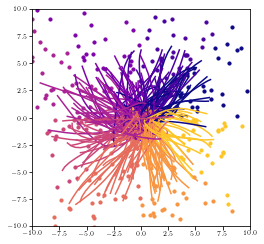

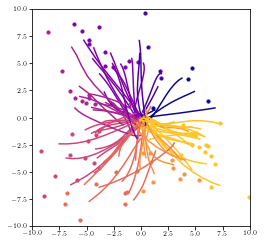

In [59]:
#subset reaches that start around the center, centered reaches, movement only, grouped
colors = utility.get_colors(n_target_groups)
df = all_reach_move_dfs[9]
plt.figure()
for i in range(len(df)):
    pos = df.pos_centered.values[i]
    targets = df.target_centered.values[i]
    target_group = df.target_group.values[i]
    plt.plot(*pos[:].T, c=colors[target_group])
    plt.scatter(*targets[:].T, s = 10, c=colors[target_group])
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

df = all_reach_move_dfs[11]
plt.figure()
for i in range(len(df)):
    pos = df.pos_centered.values[i]
    targets = df.target_centered.values[i]
    target_group = df.target_group.values[i]
    plt.plot(*pos[:].T, c=colors[target_group])
    plt.scatter(*targets[:].T, s = 10, c=colors[target_group])
plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])

In [103]:
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

#match movements

df1 = all_reach_move_dfs[9]
df2 = all_reach_move_dfs[12]

print('Ntrials:', len(df1), len(df2))

#match by target
df1_targets = np.vstack(df1.target_centered)
df2_targets = np.vstack(df2.target_centered)
distances = cdist(df1_targets,df2_targets,metric = 'euclidean')
print(df1_targets.shape, df2_targets.shape, distances.shape)
# fig, ax = plt.subplots()
# ax.imshow(distances)
closest_dist = np.min(distances.T, axis = 1)
closest_targets = np.argmin(distances.T, axis = 1)

# plt.figure()
# plt.hist((closest_dist).flatten(), color = 'b', histtype='step')
# plt.hist((distances).flatten(), color = 'r', histtype='step')
# df1_pos = np.vstack(df1.pos_centered)
# df2_pos = np.vstack(df2.pos_centered)

# match by pos corr
corrs = np.zeros([len(df1), len(df2)])
mses = np.zeros([len(df1), len(df2)])
for i, pos1 in enumerate(df1.pos_centered):
    for j, pos2 in enumerate(df2.pos_centered):
        # if j<i: continue
        r = [pearsonr(aa,bb)[0] for aa,bb in zip(pos1.T,pos2.T)]
        mse = np.mean((pos1-pos2)**2)
        corrs[i][j] = np.mean(r)
        mses[i][j] = mse
        # corrs[j][i] = np.mean(np.abs(r))
max_corrs = np.max(corrs.T, axis = 1)
closest_corr = np.argmax(corrs.T, axis = 1)

min_mses = np.min(mses.T, axis = 1)
closest_pos = np.argmin(mses.T, axis = 1)
# df1_pos = np.vstack(df1.pos_centered)
# df2_pos = np.vstack(df2.pos_centered)
# df1_pos.shape
# df1_targets.shape




Ntrials: 233 93
(233, 2) (93, 2) (233, 93)


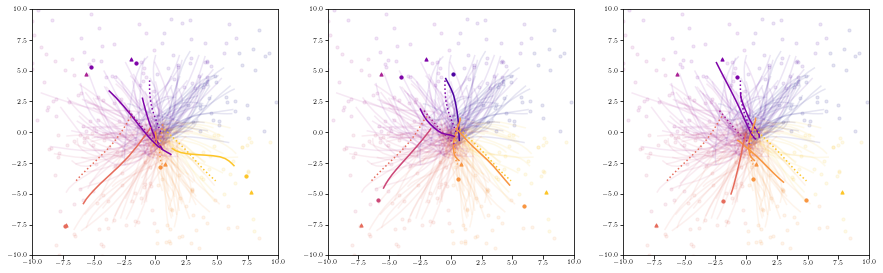

In [112]:
criteria = [closest_targets, closest_pos, closest_corr]

fig,axs = plt.subplots(ncols=len(criteria), figsize = (5*len(criteria), 5))
colors = utility.get_colors(n_target_groups)
ntrials = 5

for j, crit in enumerate(criteria):
    df = all_reach_move_dfs[9]
    for i in range(len(df)):
        pos = df.pos_centered.values[i]
        targets = df.target_centered.values[i]
        target_group = df.target_group.values[i]
        axs[j].plot(*pos[:].T, c=colors[target_group], alpha = 0.1)
        axs[j].scatter(*targets[:].T, s = 10, c=colors[target_group], alpha = 0.1)

    df = all_reach_move_dfs[9].iloc[crit]
    for i in range(ntrials):
        pos = df.pos_centered.values[i]
        targets = df.target_centered.values[i]
        target_group = df.target_group.values[i]
        axs[j].plot(*pos[:].T, c=colors[target_group])
        axs[j].scatter(*targets[:].T, s = 10, c=colors[target_group])

    df = all_reach_move_dfs[12]
    # plt.figure()
    for i in range(ntrials):
        pos = df.pos_centered.values[i]
        targets = df.target_centered.values[i]
        target_group = df.target_group.values[i]
        axs[j].plot(*pos[:].T, c=colors[target_group], linestyle = 'dotted')
        axs[j].scatter(*targets[:].T, s = 10, c=colors[target_group],marker = '^')
    axs[j].set_aspect(1)
    axs[j].set_xlim([-10,10])
    axs[j].set_ylim([-10,10])

97
32


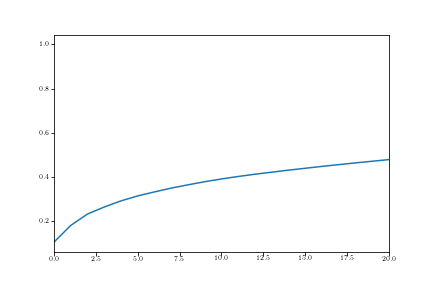

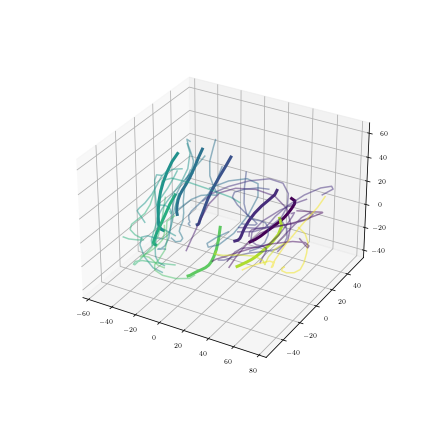

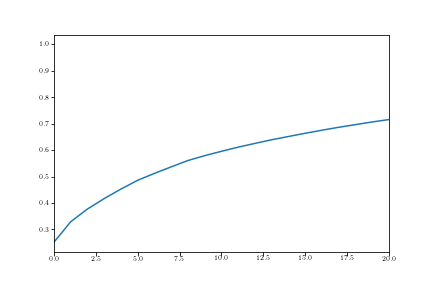

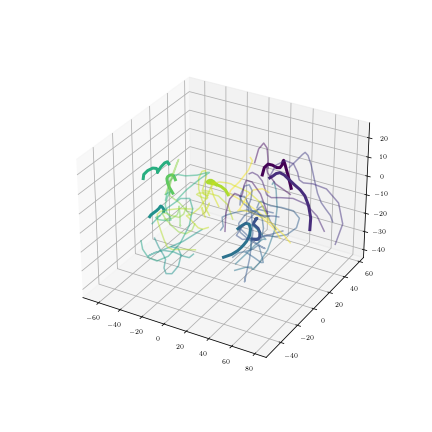

In [141]:
%matplotlib widget
# %matplotlib inline
for i in [9,12]:
    df_ = all_reach_move_dfs[i]
    #check dimensionality
    model = pyal.fit_dim_reduce_model(df_, PCA(), 'MCx_rates')
    dim = (np.nonzero((np.cumsum(model.explained_variance_ratio_) > 0.8))[0][0])
    print(dim)

    plt.figure()
    plt.plot(np.cumsum(model.explained_variance_ratio_))
    plt.xlim([0,20])

    # plot PCA
    colors = utility.get_colors(8, 'viridis')
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(projection = '3d')

    for tar in range(n_target_groups):
        df__ = pyal.select_trials(df_, df_.target_group==tar)
        ex = pyal.get_sig_by_trial(df__,'_pca')
        ex = np.mean(ex, axis=2)[:,:3]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=3)
        # ax.view_init(60,-47)

    # for i in range(len(df_)):
    for i in range(30):
        pca = df_._pca.values[i]
        angle = df_.target_angle.values[i]
        ax.plot(pca[:,0],pca[:,1],pca[:,2],c=cmap(norm(angle)), alpha=0.5)


In [145]:
#cca
df1 = all_reach_move_dfs[9]
df2 = all_reach_move_dfs[12]

#upper bound
data1 = np.concatenate(df1._pca.values, axis = 0)
data2 = np.concatenate(df2._pca.values, axis = 0)
allCCs = np.array(dt.canoncorr(data1, data2))
allCCs = np.array(allCCs).T

CCsU = []
#upper bound
for df in [df1, df2]:
    n_shared_trial1 = len(df1)
    trialList1 = np.arange(n_shared_trial1)
    r = []
    for n in range(params.n_iter * 10):
        params.rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.concatenate(df1.iloc[trial1]._pca.values, axis = 0)
        data2 = np.concatenate(df1.iloc[trial2]._pca.values, axis = 0)
        r.append(dt.canoncorr(data1, data2))
    CCsU.append(r)
CCsU = np.array(CCsU)
CCsU = np.percentile(CCsU, 99, axis=1).T

plt.figure()
plt.plot(allCCs, c = 'b')
plt.plot(CCsU, c = 'r')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1116 is different from 2796)

In [146]:
data1.shape, data2.shape

((2796, 10), (1116, 10))